In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


## Import raw data

In [2]:
import os
import sys
from google.colab import drive

try:
  drive.mount("/content/drive")
  project_path = "/content/drive/MyDrive/Pytorch pet projects/ML - Projects/ML-Store-Item-Demand-Forecasting-Challenge/data"
except:
  project_path ="../data"

df = raw_train = pd.read_csv(f"{project_path}/train.csv")
test_df = raw_test = pd.read_csv(f"{project_path}/test.csv")
ssub_df = raw_sample_submission = pd.read_csv(f"{project_path}/sample_submission.csv")

# Create reports folder for the graphs
os.makedirs("reports", exist_ok=True)

Mounted at /content/drive


## Discover data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [4]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [5]:
df.isnull().sum()

,0
date,0
store,0
item,0
sales,0


## Feature engineering
* Convert `data` to `datetime`

In [6]:
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["day_of_week"] = df["date"].dt.dayofweek
df["is_weekend"] = df["day_of_week"].isin([5,6]).astype(int)

## Visualization

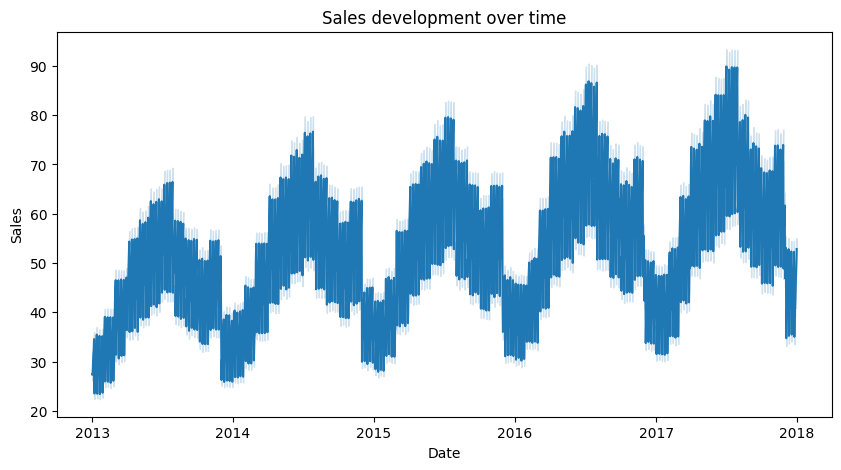

In [7]:
plt.figure(figsize=(10,5))
sns.lineplot(x="date", y="sales", data=df)
plt.title("Sales development over time")
plt.xlabel("Date")
plt.ylabel("Sales")

plt.savefig("reports/sales_development_over_time.jpg", bbox_inches='tight')
plt.show()

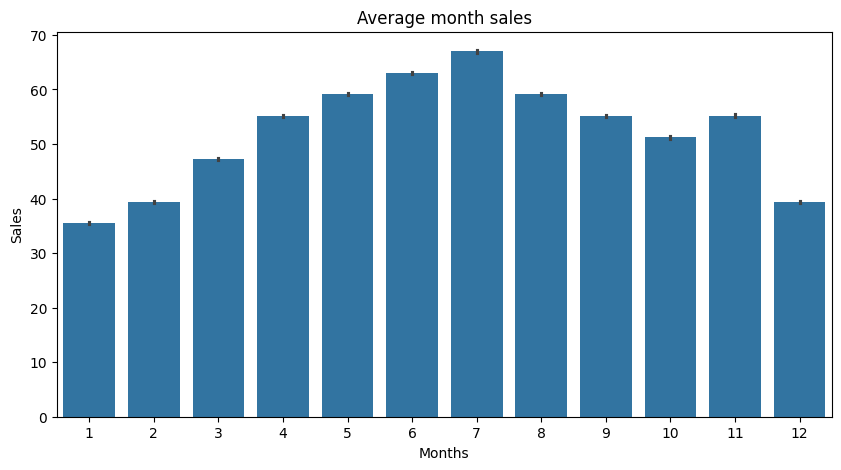

In [8]:
plt.figure(figsize=(10,5))
sns.barplot(x="month", y="sales", data=df)
plt.title("Average month sales")
plt.xlabel("Months")
plt.ylabel("Sales")

plt.savefig("reports/average_month_sales.jpg", bbox_inches="tight")
plt.show()

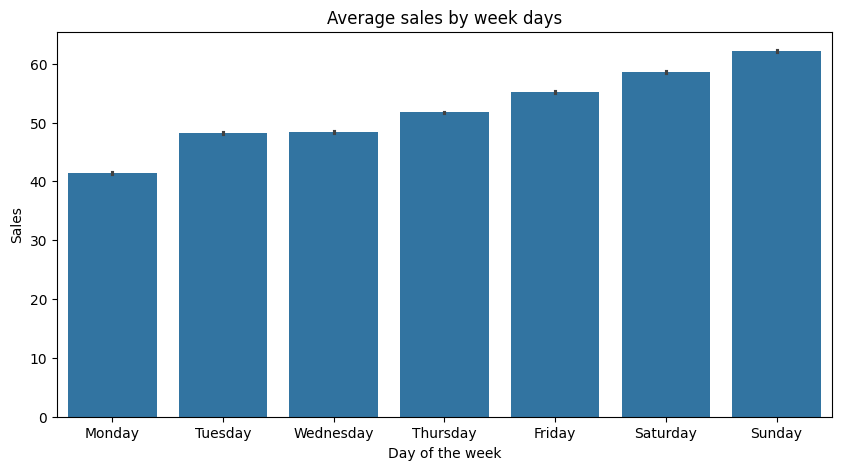

In [9]:
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(10,5))
ax = sns.barplot(x="day_of_week", y="sales", data=df)

ax.set_xticks(range(7))
ax.set_xticklabels(days_of_week)

plt.title("Average sales by week days")
plt.xlabel("Day of the week")
plt.ylabel("Sales")

plt.savefig("reports/average_sales_by_week_days.jpg", bbox_inches="tight")
plt.show();

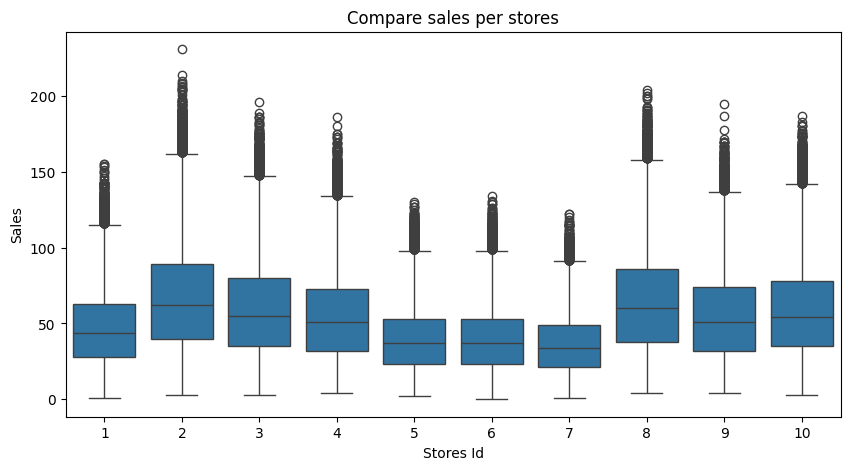

In [10]:
plt.figure(figsize=(10,5))
sns.boxplot(x="store", y="sales", data=df)
plt.title("Compare sales per stores")
plt.xlabel("Stores Id")
plt.ylabel("Sales")

plt.savefig("reports/compare_salse_by_store.jpg", bbox_inches="tight")
plt.show()

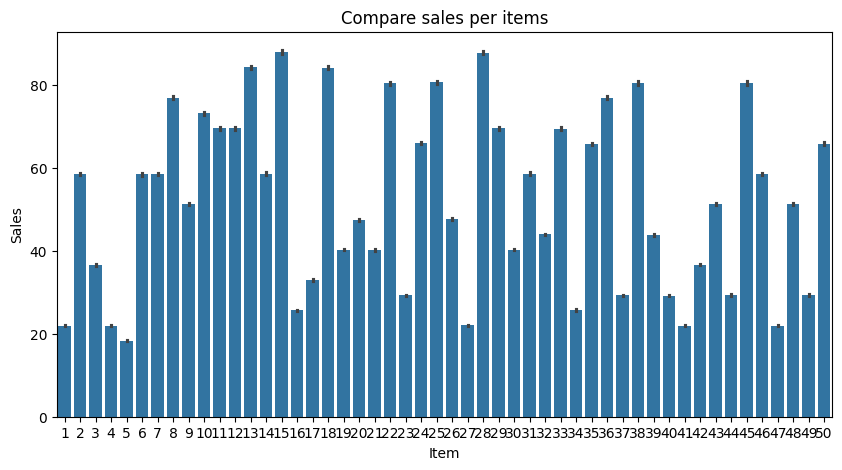

In [11]:
plt.figure(figsize=(10,5))
sns.barplot(x="item", y="sales", data=df)
plt.title("Compare sales per items")
plt.xlabel("Item")
plt.ylabel("Sales")

plt.savefig("reports/compare_sales_by_items.jpg", bbox_inches="tight")
plt.show()

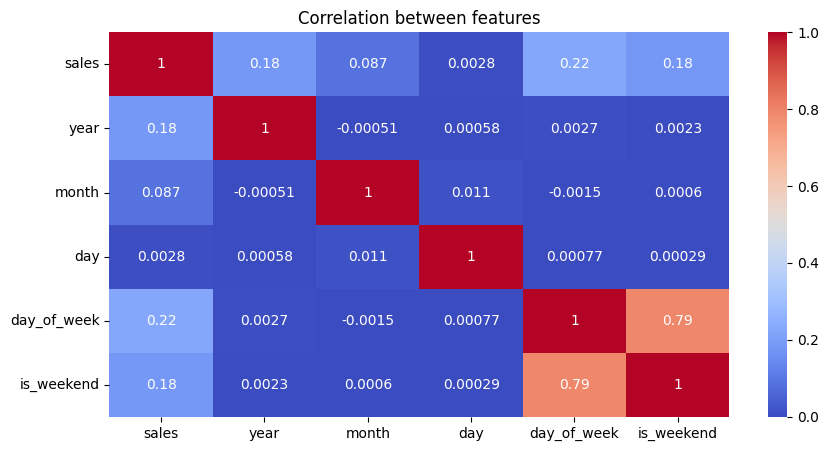

In [12]:
plt.figure(figsize=(10,5))
sns.heatmap(df[['sales', 'year', 'month', 'day', 'day_of_week', 'is_weekend']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between features")

plt.savefig("reports/correlation.jpg", bbox_inches="tight")
plt.show()

Based on the heatmap looks like there is no strong linear realashontiop between the features.

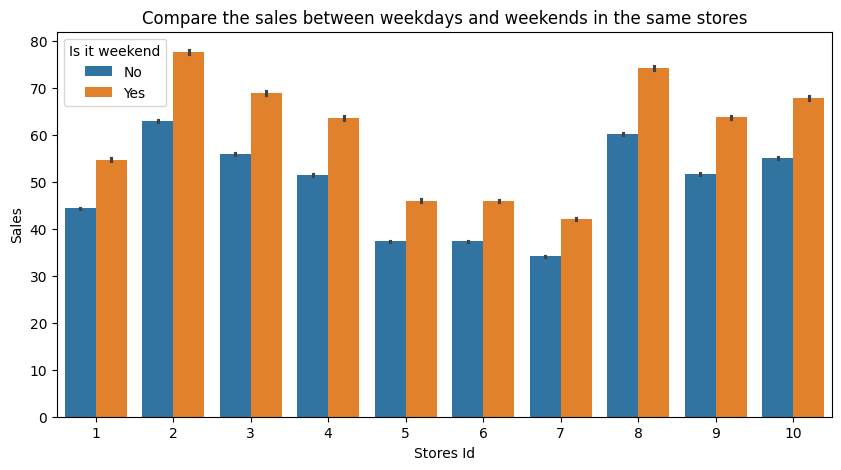

In [13]:
legend_label=["No", "Yes"]

plt.figure(figsize=(10,5))
ax = sns.barplot(x="store", y="sales", data=df, hue="is_weekend")

h, l = ax.get_legend_handles_labels()
ax.legend(h, legend_label, title="Is it weekend")

plt.title("Compare the sales between weekdays and weekends in the same stores")
plt.xlabel("Stores Id")
plt.ylabel("Sales")

plt.savefig("reports/salse_weekdays_vs_weekends.jpg", bbox_inches="tight")
plt.show()

Based on the barplot all the stores has a bigger sales numbers on the weekend

## Remove outliers before statistical test

In [14]:
# %%writefile data_processing.py

import pandas as pd

def remove_outliers_iqr(columns: list, data: pd.DataFrame) -> pd.DataFrame:
  """
    Removes outliers from the specified columns of a DataFrame using the IQR method.

    The function calculates the interquartile range (IQR) for the given columns and
    removes rows where values are outside the lower and upper bounds
    (Q1 - 1.5 * IQR and Q3 + 1.5 * IQR).

    Args:
        columns (list): List of column names from which outliers should be removed.
        df (pd.DataFrame): The DataFrame containing the data.

    Returns:
        pd.DataFrame: A new DataFrame with outliers removed from the specified columns.
    """
  Q1 = data[columns].quantile(0.25)
  Q3 = data[columns].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  mask = (data[columns] >= lower_bound) & (data[columns] <= upper_bound)
  return data[mask.all(axis=1)].copy()

In [15]:
df = remove_outliers_iqr(["sales"], df)

## Statistical test
* kruskal
* mannwhitneyu
* adfuller (time period statistical test)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 901033 entries, 0 to 912999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         901033 non-null  datetime64[ns]
 1   store        901033 non-null  int64         
 2   item         901033 non-null  int64         
 3   sales        901033 non-null  int64         
 4   year         901033 non-null  int32         
 5   month        901033 non-null  int32         
 6   day          901033 non-null  int32         
 7   day_of_week  901033 non-null  int32         
 8   is_weekend   901033 non-null  int64         
dtypes: datetime64[ns](1), int32(4), int64(4)
memory usage: 55.0 MB


In [17]:
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from statsmodels.tsa.stattools import adfuller

df_lite = df[:160]

weekend = df_lite[df_lite['is_weekend']==1]['sales']
weekday = df_lite[df_lite['is_weekend']==0]['sales']

stat, p = mannwhitneyu(weekend, weekday)
print(f'U-stat: {stat}, p-value: {p:.5f}')
print("There is a significant difference between the sales on different week and on weekdays")

U-stat: 3594.5, p-value: 0.00024
There is a significant difference between the sales on different week and on weekdays


In [18]:
from scipy.stats import kruskal

h, p = kruskal(df_lite[df_lite['day_of_week']==0]['sales'],
               df_lite[df_lite['day_of_week']==1]['sales'],
               df_lite[df_lite['day_of_week']==2]['sales'],
               df_lite[df_lite['day_of_week']==3]['sales'],
               df_lite[df_lite['day_of_week']==4]['sales'],
               df_lite[df_lite['day_of_week']==5]['sales'],
               df_lite[df_lite['day_of_week']==6]['sales'],
)
print(f'H-stat: {h}, p-value: {p:.5f}')
print("There is a significant difference between the sales on different days")

H-stat: 23.106453269698545, p-value: 0.00076
There is a significant difference between the sales on different days


In [19]:
one_year_sales_df = df[df["year"] == 2017]

sales_by_month = [df[df['month']==m]['sales'] for m in range(1,13)]
h, p = kruskal(*sales_by_month)

print(f'H-statisztika: {h:.3f}, p-value: {p:.5f}')


H-statisztika: 85793.596, p-value: 0.00000


### ADF
* Check if the time period is stationary or not (Stationary is good bc we dont need to make differentiation/transformation on the data before modeling)


In [20]:
result = adfuller(one_year_sales_df.set_index("date")["sales"])
print('ADF statistic:', result[0])
print('p-value:', result[1])


if result[1] < 0.05:
    print("Stationary. There is not trend, can be use directly for a model")
else:
    print("Not stationary. Differentiation/transformation required before model")

ADF statistic: -16.766762345632472
p-value: 1.296745636408577e-29
Stationary. There is not trend, can be use directly for a model


### ACF / PACF
* Used to find the best parameters for the ARIMA model
* ARIMA model takes 3 parameter (p, d, q)
  * p: how many previous values ​​("autoregressive" → AR part) it tries to predict the current value from.

  * d: degree of differentiation (in your case d=0, because it is already stationary).

  * q: how many previous errors ("moving average" → MA part) are needed to predict the current value.


* ACF plot helps to find the value of q (the MA component).
* PACF plot helps to find the value of p (the AR component).


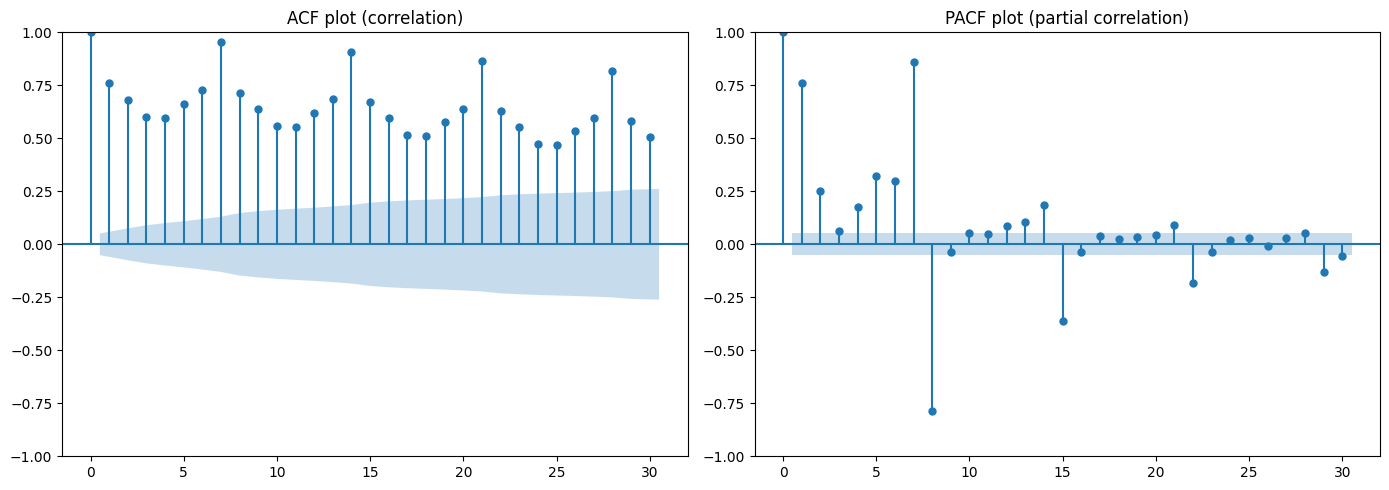

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

data_before_2017 = df[df["year"] <= 2016]

sales_ts = data_before_2017.set_index('date')['sales'].resample('D').mean().dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 sor, 2 oszlop

# ACF plot
plot_acf(sales_ts, lags=30, ax=axes[0])
axes[0].set_title("ACF plot (correlation)")

# PACF plot
plot_pacf(sales_ts, lags=30, ax=axes[1])
axes[1].set_title("PACF plot (partial correlation)")

plt.tight_layout()

plt.savefig("reports/acf_pacf_plot.jpg", bbox_inches="tight")
plt.show()


## Armia model

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1461
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -4764.115
Date:                Sun, 23 Mar 2025   AIC                           9538.230
Time:                        11:12:46   BIC                           9564.664
Sample:                    01-01-2013   HQIC                          9548.091
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.3727      6.080      7.627      0.000      34.457      58.289
ar.L1          1.2106      0.043     27.922      0.000       1.126       1.296
ar.L2         -0.2136      0.043     -4.941      0.0

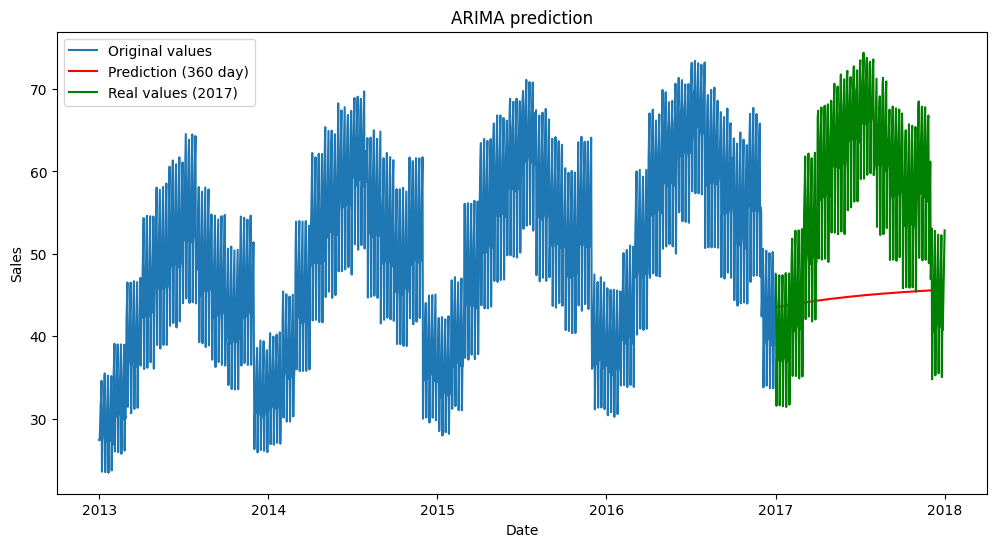

In [22]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# preparation of a timeline
data_before_2017 = df[df["year"] <= 2016]
data_2017 = df[df["year"] == 2017]

sales_ts = data_before_2017.set_index('date')['sales'].resample('D').mean().dropna()
sales_2017_ts = data_2017.set_index('date')['sales'].resample('D').mean().dropna()


# creating ARIMA model
model = ARIMA(sales_ts, order=(2,0,1))

# fit the model
model_fit = model.fit()

# print the result
print(model_fit.summary())

# create a prediction for the next 360 day
forecast = model_fit.forecast(steps=360)

# plot the prediction
plt.figure(figsize=(12,6))
plt.plot(sales_ts, label='Original values')
plt.plot(forecast, label='Prediction (360 day)', color='red')
plt.plot(sales_2017_ts, label='Real values (2017)', color='green')
plt.legend()
plt.title('ARIMA prediction')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.savefig("reports/arima_prediction.jpg", bbox_inches="tight")
plt.show()


### Conclusion
* ARIMA is good for modeling sort timelines but not for seasons
* For bigger data lets use SARIMA

## Sarima model

In [1]:
import statsmodels.api as sm

# preparation of a timeline
data_before_2017 = df[df["year"] <= 2014]
data_2017 = df[df["year"] == 2015]

sales_ts = data_before_2017.set_index('date')['sales'].resample('D').mean().dropna()
sales_2017_ts = data_2017.set_index('date')['sales'].resample('D').mean().dropna()


sarima_model = sm.tsa.statespace.SARIMAX(
    sales_ts,
    order=(2,0,1),
    seasonal_order=(1,1,1,365) # (p,d,q, cyrcle length)
)

sarima_fit = sarima_model.fit()

forecast_sarima = sarima_fit.get_forecast(steps=360).predicted_mean

plt.figure(figsize=(12,6))
plt.plot(sales_ts, label='Original value (train)')
plt.plot(sales_2017_ts, label='Real values (2017)', color='green')
plt.plot(forecast_sarima, label='SARIMA prediction', color='orange')
plt.legend()
plt.title('SARIMA(2,0,1)(1,1,1,365) prediction')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.savefig("reports/sarima_prediction.jpg", bbox_inches="tight")
plt.show()

## Conclusion
* On the weekend the sales numbers are bigger then on the weekend
* We can find a trend, on the summer the sales numbers are bigger then average